모듈 임포트

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import datetime
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
import seaborn as sns

sqlite DB에서 데이터 불러오기

In [2]:
con = sqlite3.connect(r"C:\Users\구남이\OneDrive\바탕 화면\활동들\한이음 멘토링\stock.db")
df = pd.read_sql("SELECT * FROM '039490'", con, index_col=None)
df.rename(columns={'index':'date'}, inplace=True)
df = df.set_index('date')
df

,open,high,low,close,volume
date,,,,,
20220517,85000,87600,85000,87600,55677
20220516,86900,87600,85700,85900,55383
20220513,84000,87400,83500,85800,86525
20220512,84700,85300,82700,83200,104007
20220511,87500,87500,85500,85800,108071
...,...,...,...,...,...
20040429,5117,5436,5025,5101,109911
20040428,5071,5452,4995,5444,182604
20040427,5452,5482,5033,5063,299489


데이터 정렬

In [3]:
df.sort_index(ascending=True, inplace=True)
df

,open,high,low,close,volume
date,,,,,
20040423,6076,6799,5353,5353,1415109
20040426,5436,5741,5261,5398,343283
20040427,5452,5482,5033,5063,299489
20040428,5071,5452,4995,5444,182604
20040429,5117,5436,5025,5101,109911
...,...,...,...,...,...
20220511,87500,87500,85500,85800,108071
20220512,84700,85300,82700,83200,104007
20220513,84000,87400,83500,85800,86525


In [4]:
df.index = pd.DatetimeIndex(df.index)
df.index

DatetimeIndex(['2004-04-23', '2004-04-26', '2004-04-27', '2004-04-28',
               '2004-04-29', '2004-04-30', '2004-05-03', '2004-05-04',
               '2004-05-06', '2004-05-07',
               ...
               '2022-05-03', '2022-05-04', '2022-05-06', '2022-05-09',
               '2022-05-10', '2022-05-11', '2022-05-12', '2022-05-13',
               '2022-05-16', '2022-05-17'],
              dtype='datetime64[ns]', name='date', length=4471, freq=None)

시각화

Text(0, 0.5, 'price')

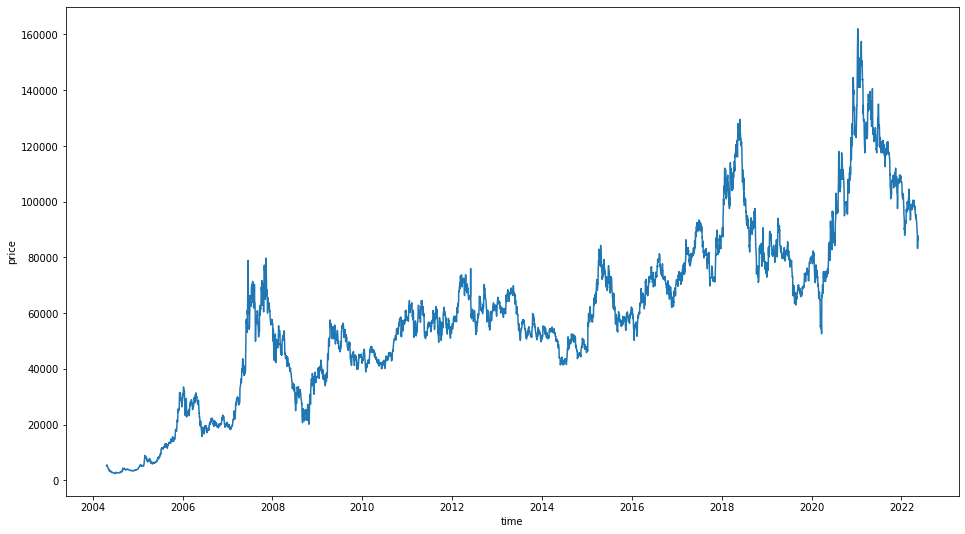

In [5]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

데이터 스케일링 (Min_max 정규화)

In [6]:
from sklearn.preprocessing import MinMaxScaler

# 피처값 스케일링
scaler = MinMaxScaler()
df[['open','high','low','volume']] = scaler.fit_transform(df[['open','high','low','volume']])

# 타켓 스케일링
scaler1 = MinMaxScaler()
df['close'] = scaler1.fit_transform(df['close'].values.reshape(-1,1))

# 스케일링 결과 확인
df

,open,high,low,close,volume
date,,,,,
2004-04-23,0.022741,0.026226,0.019066,0.018324,1.000000
2004-04-26,0.018743,0.019815,0.018467,0.018606,0.241077
2004-04-27,0.018842,0.018245,0.016982,0.016507,0.210068
2004-04-28,0.016462,0.018063,0.016734,0.018894,0.127305
2004-04-29,0.016750,0.017967,0.016930,0.016745,0.075834
...,...,...,...,...,...
2022-05-11,0.531437,0.515237,0.540941,0.522470,0.074531
2022-05-12,0.513944,0.501906,0.522709,0.506176,0.071653
2022-05-13,0.509571,0.514631,0.527918,0.522470,0.059275


train,test set 나누기 (차원 하나 늘려야 하기 때문에 array형식으로 나누기)

In [7]:
#train/test size 설정
train_size = int(len(df)*0.8)

#train/test 학습 및 라벨 설정
#종가를 예측하기 위해 종가를 label로 설정
train_x = np.array(df[:train_size])
train_y = np.array(df['close'][:train_size])

test_x = np.array(df[train_size:])
test_y = np.array(df['close'][train_size:])

print(len(train_x))
print(len(test_x))
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

3576
895
(3576, 5)
(3576,)
(895, 5)
(895,)


파라미터 설정

In [8]:
learning_rate = 0.01
training_cnt = 100
batch_size = 200
input_size = train_x.shape[1]

time_step = 1

차원 맞추기

RNN 모델에서는 시간을 고려해야하기 때문에 차원을 하나 늘려준다.

(데이터의수, feature) -> (데이터의수, 시간, feautre)

In [9]:
learning_rate = 0.01
training_cnt = 100
batch_size = 200
input_size = train_x.shape[1]

time_step = 1

# reshape into (size(개수), time step, 입력 feature)
train_x = train_x.reshape(train_x.shape[0],1,input_size)
test_x = test_x.reshape(test_x.shape[0], 1, input_size)
train_x.shape, test_x.shape

((3576, 1, 5), (895, 1, 5))

학습하기

1) 모델 구조 설정 및 학습

In [10]:
# 모델구조
model = Sequential()
model.add(SimpleRNN(512,input_shape=(time_step,input_size))) # 512는 다른숫자로도 사용가능
# model.add(Dense(512, activation='tanh'))
model.add(Dense(1,activation='tanh')) #output(target)은 '종가'이기 때문에 1요소 = Dense의 output레이어는 1로 설정
model.add(Dropout(0.2))

#오차 및 최적화기 설정
model.compile(loss='mse',optimizer='rmsprop',metrics=['mae','mape'])
model.summary()

#학습
history = model.fit(train_x, train_y, epochs=training_cnt, batch_size=batch_size, verbose=1)
val_mse, val_mae, val_mape = model.evaluate(test_x, test_y, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 512)               265216    
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
Total params: 265,729
Trainable params: 265,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 4s 18ms/step - loss: 0.0308 - mae: 0.0983 - mape: 22002.7676
Epoch 2/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0247 - mae: 0.0884 - mape: 8201.2627
Epoch 3/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0223 - mae: 0.0884 - mape: 6186.8892
Epoch 4/100
18/18 [=====================

2) test 셋으로 실제값과 예측값 차이 확인

In [11]:
pred = model.predict(test_x)

print(pred.shape)
print(test_y.shape)

(895, 1)
(895,)


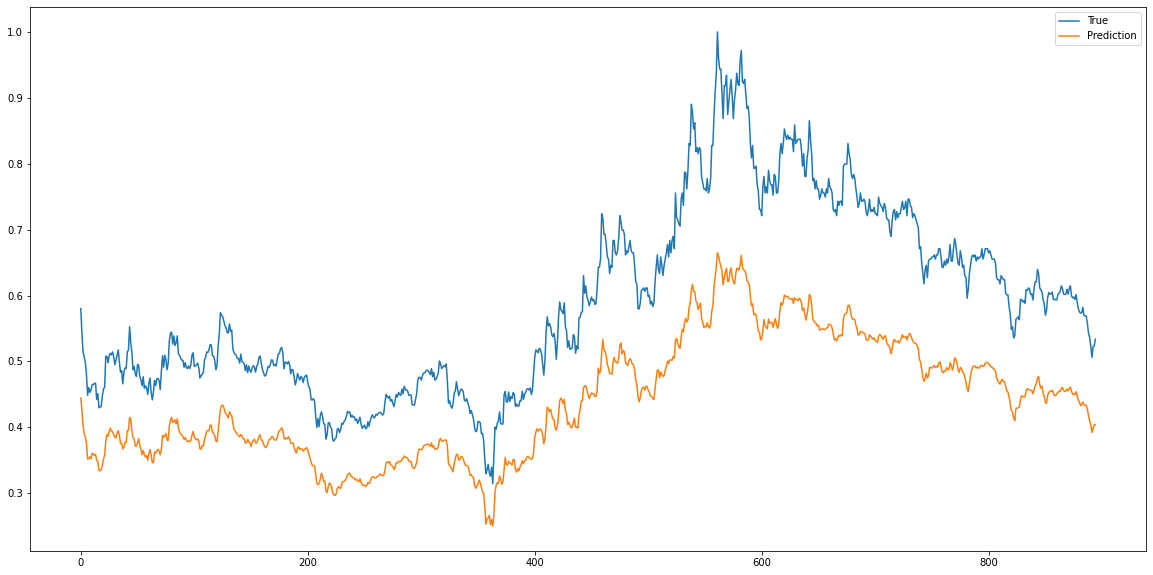

In [12]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(test_y, label='True')
ax.plot(pred, label='Prediction')

ax.legend()
plt.show()

스케일링 전으로 역변환

In [13]:
rescaled_y_test = scaler1.inverse_transform(np.array(test_y).reshape(-1, 1))
rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))

print(rescaled_y_test.shape)
print(rescaled_pred.shape)

(895, 1)
(895, 1)


MSE 계산

In [14]:
MSE = np.square(np.subtract((rescaled_y_test), rescaled_pred)).mean()
MSE

624056659.6355261

RMSE 계산

In [15]:
import math
rmse = math.sqrt(MSE)
rmse

24981.126068204492

시각화

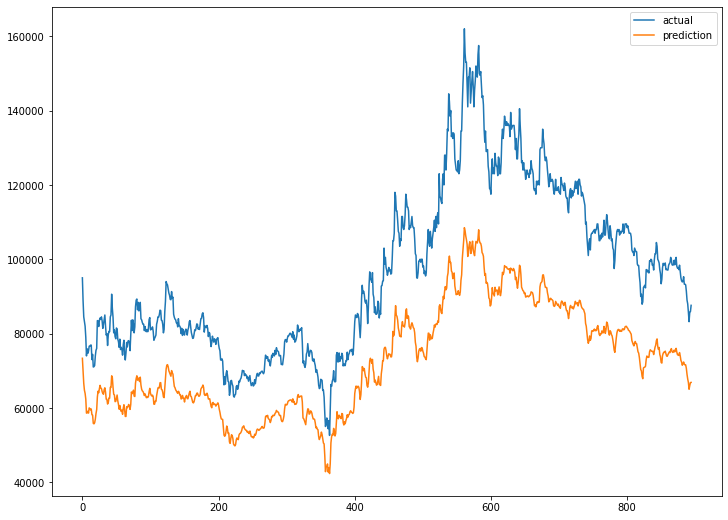

In [16]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(rescaled_y_test), label='actual')
plt.plot(rescaled_pred, label='prediction')
plt.legend()
plt.show()